In [11]:
from utils.LLM import model

In [12]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]


model_with_tools = model.bind_tools(tools)

In [13]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}

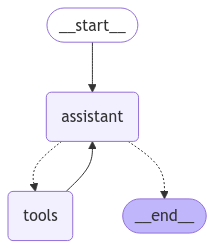

In [14]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# create checkpoint
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [15]:
# specify thread
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_0_0bdd6628-a8d9-4135-b955-ea94ed5af275)
 Call ID: call_0_0bdd6628-a8d9-4135-b955-ea94ed5af275
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================


In [17]:
messages = [HumanMessage(content="Multiply that by 2. ")]
messages = react_graph.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_0_0bdd6628-a8d9-4135-b955-ea94ed5af275)
 Call ID: call_0_0bdd6628-a8d9-4135-b955-ea94ed5af275
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
================================ Human Message =================================

Multiply that by 2. 
================================ Human Message =================================

Multiply that by 2. 
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0_e3953293-4887-4b74-a631-364789e7d511)
 Call ID: call_0_e3953293-4887-4b74-a631-364789e7d511
  Args:
    a: 7
    b: 2
================================= Tool Message ======================

In [19]:
messages = [HumanMessage(content="summarize the steps")]
messages = react_graph.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)